In [2]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt

In [3]:
# Question 2

X = np.array(
    [[0.2, 3.1, 1],
     [1.0, 3.0, 1],
     [-0.2, 1.2, 1],
     [1.0, 1.1, 1]])
     
y = np.array([1, 1, 0, 0])
w_0 = np.array([-1, 1, 0])

def logistic(x):
    return 1 / (1 + np.exp(-x))

def calc_si(X, w):
    return logistic(np.dot(X, w))

def calc_wi(X, w, s):
    omega = np.diag(np.multiply(s, 1 - s))
    X_tOX_inv = np.linalg.inv(X.T.dot(omega).dot(X))
    X_tys = X.T.dot(y - s)
    return w + X_tOX_inv.dot(X_tys)

np.set_printoptions(precision=4)

# Part a
s_0 = calc_si(X, w_0)
print(s_0)

# Part b
w_1 = calc_wi(X, w_0, s_0)
print(w_1)

# Part c
s_1 = calc_si(X, w_1)
print(s_1)

# Part d
w_2 = calc_wi(X, w_1, s_1)
print(w_2)

[0.9478 0.8808 0.8022 0.525 ]
[ 1.3247  3.0499 -6.8291]
[0.9474 0.9746 0.0312 0.1044]
[ 1.366   4.1575 -9.1996]


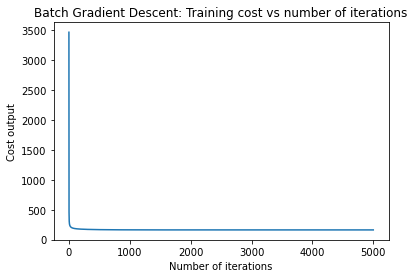

99.4


In [87]:
# Question 3

np.random.seed(42)

# Loading data, adding extra feature, normalizing, dividing into val/ train/ test

def load_data(data_name):
    data = scipy.io.loadmat(data_name)
    train_data = data['X']
    train_labels = data['y']
    test_data = data['X_test']
    return train_data, train_labels, test_data

def normalize_add_feature(train_data_raw, test_data_raw):
    means = [np.mean(train_data_raw[:, i]) for i in range(0, len(train_data_raw[0]))]
    stds = [np.std(train_data_raw[:, i]) for i in range(0, len(train_data_raw[0]))]
    for i in range(0, len(train_data_raw[0])):
        train_data_raw[:, i] = train_data_raw[:, i] - means[i]
        train_data_raw[:, i] = train_data_raw[:, i] / stds[i]
        test_data_raw[:, i] = test_data_raw[:, i] - means[i]
        test_data_raw[:, i] = test_data_raw[:, i] / stds[i]
    fict_dim_train = np.ones((len(train_data_raw), 1))
    train_data_final = np.append(train_data_raw, fict_dim_train, axis=1)
    fict_dim_test = np.ones((len(test_data_raw), 1))
    test_data_final = np.append(test_data_raw, fict_dim_test, axis=1)
    return train_data_final, test_data_final

def shuffle_split(full_data, labels, val_data_size):
    size = len(full_data)
    assert size == len(labels)
    assert val_data_size >= 0
    if val_data_size < 1.0:
        val_data_size = int(val_data_size * size)
    permute = np.random.permutation(size)
    train_data_size = size - val_data_size
    train_data, train_labels = full_data[permute][:train_data_size], labels[permute][:train_data_size]
    val_data, val_labels = full_data[permute][train_data_size:], labels[permute][train_data_size:]
    return train_data, train_labels, val_data, val_labels

data_name = f"data.mat"
data, labels, test_data = load_data(data_name)
normalized_data, normalized_test_data = normalize_add_feature(data, test_data)
train_data, train_labels, val_data, val_labels = shuffle_split(normalized_data, labels, 1000)

# Logistic Regression

def logistic_reg(X, w):
    s = np.zeros((X.shape[0], 1))
    for i in range(0, X.shape[0]):
        s[i] = np.true_divide(1, 1 + np.exp(-np.dot(X[i], w)))
    return s

# Batch Gradient Descent

def batch_grad_desc(X, w, y, learn_rate, reg_param, num_iter):
    cost = np.zeros((num_iter + 1, ))
    s = logistic_reg(X, w)
    cost[0] = -np.dot(y.T, np.log(s)) - np.dot((1-y).T, np.log(1-s)) + ((reg_param/2)*np.sum(np.square(w)))
    for ite in range(0, num_iter):
        gradJ = reg_param*w - np.dot(X.T, y - s)
        w = w - learn_rate*gradJ
        s = logistic_reg(X, w)
        cost[ite+1] = -np.dot(y.T, np.log(s)) - np.dot((1-y).T, np.log(1-s)) + ((reg_param/2)*np.sum(np.square(w)))
    return w, s, cost

reg_param = 0.00001
learn_rate = 0.001
num_iter = 5000
w = np.zeros((len(train_data[0]), 1))
w_final, s_final, cost = batch_grad_desc(train_data, w, train_labels, learn_rate, reg_param, num_iter)

# Plotting cost function vs num iters

plt.plot(np.arange(num_iter+1), cost)
plt.xlabel("Number of iterations")
plt.ylabel("Cost output")
plt.title("Batch Gradient Descent: Training cost vs number of iterations")
plt.show()

# Testing accuracy on validation data

s_val = logistic_reg(val_data, w_final)
diff = np.rint(s_val) - val_labels
acc = (np.true_divide(diff.size - np.count_nonzero(diff), val_labels.size)) * 100
print(acc)


In [ ]:
# Hyperparamter Tuning using Cross Validation

results = []
reg_param_arr = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
learn_rate_arr = [0.001, 0.0001, 0.00001, 0.000001]
iter_arr = [5000, 6000, 7000, 8000]
size = len(normalized_data)
permute = np.random.permutation(size)
part_size = size // 3
wine_train_permute = normalized_data[permute]
wine_labels_permute = labels[permute]
for val in iter_arr:
    for learn in learn_rate_arr:
        for reg in reg_param_arr:
            val_scores = []
            for i in range(0, 3):
                print(i)
                wine_val_data = wine_train_permute[i*part_size:(i+1)*part_size]
                wine_val_labels = wine_labels_permute[i*part_size:(i+1)*part_size]
                wine_train_data = np.concatenate((wine_train_permute[:i*part_size], 
                                                 wine_train_permute[(i+1)*part_size:]), axis=0)
                wine_train_labels = np.concatenate((wine_labels_permute[:i*part_size], 
                                                  wine_labels_permute[(i+1)*part_size:]), axis=0)
                w_final, s_final, cost = batch_grad_desc(wine_train_data, w, wine_train_labels, learn, reg, val)
                s_val = logistic_reg(wine_val_data, w_final)
                diff = np.rint(s_val) - wine_val_labels
                acc = (np.true_divide(diff.size - np.count_nonzero(diff), wine_val_labels.size)) * 100
                val_scores.append(acc)
            results.append((val, learn, reg, np.mean(val_scores)))
            print(results)
opt_c = max(results, key=lambda x: x[3])
print(opt_c)

[3465.7359 2664.3132 2651.1008 ... 2595.9161 2595.9161 2595.9161]


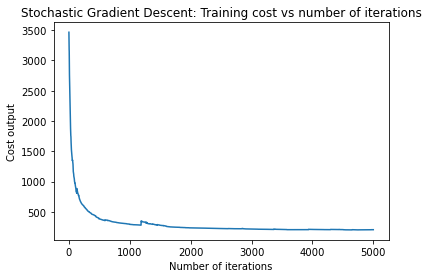

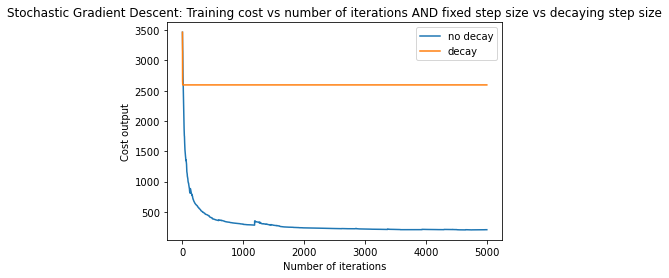

In [79]:
# Stochastic Gradient Descent

np.random.seed(42)

def stoch_grad_descent(X, w, y, learn_rate, reg_param, num_iter, var_step):
    index = 0
    cost = np.zeros((num_iter + 1, ))
    s = logistic_reg(X, w)
    cost[0] = -np.dot(y.T, np.log(s)) - np.dot((1-y).T, np.log(1-s)) + ((reg_param/2)*np.sum(np.square(w)))
    for ite in range(0, num_iter):
        if index == X.shape[0]:
            data = np.append(X, y)
            np.shuffle(data)
            X, y = data[:, :len(data[0])], data[:, len(data[0])]
            index = 0
        if var_step:
            learn_rate = np.true_divide(learn_rate, ite+1)
        gradJ = reg_param*w - (X.shape[0]*(y - s)[index]*X[index].T).reshape((-1, 1))
        w = w - learn_rate*gradJ
        s = logistic_reg(X, w)
        cost[ite+1] = -np.dot(y.T, np.log(s)) - np.dot((1-y).T, np.log(1-s)) + ((reg_param/2)*np.sum(np.square(w)))
        index += 1
    return w, s, cost

# For constant step size

reg_param = 0.1
learn_rate = 0.00001
num_iter = 5000
w = np.zeros((len(train_data[0]), 1))
w_final, s_final, cost = stoch_grad_descent(train_data, w, train_labels, learn_rate, reg_param, num_iter, False)

# For variable step size

learn_rate_var = 0.0001
w_var_final, s_var_final, cost_var = stoch_grad_descent(train_data, w, train_labels, learn_rate_var, 
                                                        reg_param, num_iter, True)

# Plotting cost function vs num iters

plt.plot(np.arange(num_iter+1), cost)
plt.xlabel("Number of iterations")
plt.ylabel("Cost output")
plt.title("Stochastic Gradient Descent: Training cost vs number of iterations")
plt.show()

# Plotting cost function vs num iters for both types of step sizes

plt.plot(np.arange(num_iter+1), cost, label="no decay")
plt.plot(np.arange(num_iter+1), cost_var, label="decay")
plt.xlabel("Number of iterations")
plt.ylabel("Cost output")
plt.legend()
plt.title("Stochastic Gradient Descent: Training cost vs number of iterations AND fixed step size vs decaying step size")
plt.show()

In [92]:
# Kaggle
import csv

with open('hw4_wine_test', mode='w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(['Id', 'Category'])
    reg_param = 0.00001
    learn_rate = 0.001
    num_iter = 5000
    w = np.zeros((len(normalized_data[0]), 1))
    w_final, s_final, cost = batch_grad_desc(normalized_data, w, labels, learn_rate, reg_param, num_iter)
    s_test = logistic_reg(normalized_test_data, w_final)
    s_test_final = (np.rint(s_test)).astype(int)
    for idx, x in enumerate(s_test_final):
        writer.writerow([idx+1, x[0]])

[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]


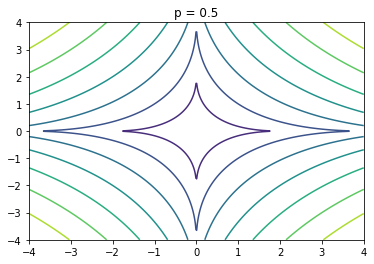

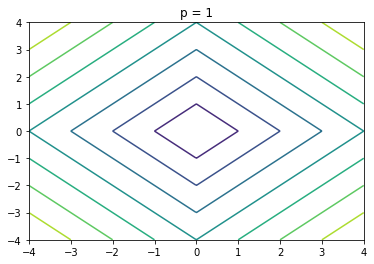

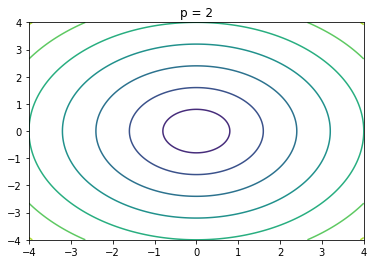

In [76]:
# Question 5
def lp_norm(X, Y, p):
    return (np.abs(X)**p + np.abs(Y)**p)**(1/p)

x = np.linspace(-4, 4, 500)
y = np.linspace(-4, 4, 500)
X, Y = np.meshgrid(x, y)

# part a
W = lp_norm(X, Y, 0.5)
plt.contour(X, Y, W)
plt.title("p = 0.5")
plt.show()

# part b
W = lp_norm(X, Y, 1)
plt.contour(X, Y, W)
plt.title("p = 1")
plt.show()

# part c
W = lp_norm(X, Y, 2)
plt.contour(X, Y, W)
plt.title("p = 2")
plt.show()